# Fabrication additive

In [1]:
import ufl
import os 
import matplotlib.pyplot as plt
import numpy as np
import dolfin as df
%matplotlib inline
plt.rcParams['figure.figsize']=(20, 15)
#df.parameters["plotting_backend"] = "vtk"

### Données géométriques (SI)

In [2]:
# SLM 500 (longueur, largeur, épaisseur d'une couche)
L = 0.5 # [m]
l = 0.28 # [m]
e = 100.e-6 # [m]
# Puissance du laser
P = 400. # [W]
# Vitesse de balayage du laser
v_laser = 1.6 # vitesse du laser [m/s]
d_laser = 0.01  # diametre du laser [m]

### Données matériau (SI)

In [3]:
# Caractéristiques de Ta6V
E = 112.E9 # module d'Young [Pa]
nu = 0.34 # coefficient de Poisson
mu = df.Constant(E/(2.*(1.+nu))) # coeffient de Lamé [Pa]
lmbda = df.Constant(E*nu/((1.+nu)*(1.-2.*nu))) # coeffient de Lamé [Pa]
K = 6.2 # conductivité thermique [W/m/K]
Cp = 2.3e6 # capacité calorifique volumique [J/m3/K]
#Cp = Cpv*L*l*e # capacité calorifique [J/K]
alpha = 8.E-6 # coefficient de dilatation [1/K]

### Maillage

In [4]:
x1min, x1max = 0, L
x2min, x2max = 0, l
x3min, x3max = 0, e

### Création d'un fichier paraview

In [5]:
file_mesh = df.File("gauss8/essai.pvd")

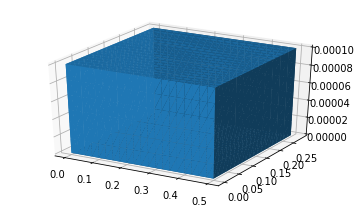

In [6]:
#T1 = df.Constant(100.)
#T0 = df.Constant(0.)

p0 = df.Point(x1min, x2min, x3min);
p1 = df.Point(x1max, x2max, x3max);
mesh = df.BoxMesh(p0, p1, 20, 20, 6)
file_mesh << (mesh)
df.plot(mesh)

ndim = mesh.geometric_dimension()

In [7]:
def boundary(x, on_boundary):
    return on_boundary

### Initialisation temporelle

In [8]:
num_steps = 10000     # number of time steps
dt = d_laser/v_laser  # time increment
T = dt*num_steps   # final time

### Initialisation thermique

In [9]:
V = df.FunctionSpace(mesh, 'P', 1)

# Condition initiale
u_D = df.Constant('0.')
bc = df.DirichletBC(V, u_D, boundary)

# Define initial value
u_n = df.interpolate(u_D, V)

In [10]:
class Up(df.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return df.near(x[2], x3max, tol) and on_boundary
Up = Up()    

class Down(df.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return df.near(x[2], x3min, tol) and on_boundary
Down = Down()

boundaries = df.MeshFunction("size_t", mesh,2)
boundaries.set_all(0)
ds = df.Measure("ds",subdomain_data=boundaries)

Up.mark(boundaries, 1)
Down.mark(boundaries, 2)

x11 = 0.
x22 = 0.

# Define variational problem
u_ = df.TrialFunction(V)    
v = df.TestFunction(V)
u = df.Function(V)

f = df.Expression('x[2]>x3max-eps/10000.?P*exp(- (pow((x[0]- x11), 2) + pow((x[1] - x22), 2))/(2.*d_laser*d_laser)):0.', P=P, x11=x11, x22=x22, d_laser=d_laser, x3max=x3max,eps=df.DOLFIN_EPS,degree=2)
#f = df.Expression('P/(d_laser*sqrt(2.*pi))*exp(- (pow((x[0]- x11), 2) + pow((x[1] - x22), 2))/(2.*d_laser))', P=P, x11=x11, x22=x22, d_laser=d_laser, x3max=x3max,eps=df.DOLFIN_EPS,degree=2)

#(d_laser*sqrt(2.*pi))

a = Cp*u_*v*df.dx + K*dt*df.dot(df.grad(u_), df.grad(v))*df.dx
L = (Cp*u_n*v*df.dx + dt*f*v*df.dx)

### Initialisation élastique

In [11]:
element = df.VectorElement("P", df.tetrahedron, degree = 1, dim=ndim)
D = df.FunctionSpace(mesh, element)
d_ = df.TrialFunction(D)
p = df.TestFunction(D)
d = df.Function(D)
 
def eps(d):
    return df.sym(df.grad(d))
def eps_th(u):
    return alpha*u*df.Identity(ndim)

a_d = df.inner((lmbda*df.tr(eps(d_))*df.Identity(ndim) - 2.*mu*eps(d_)), eps(p))*df.dx
l_d = df.inner((3.*lmbda+2.*mu)*alpha*u*df.Identity(ndim),eps(p))*df.dx

# Condition limite
bc_d = df.DirichletBC(D, (0.,0.,0.), Down)

### Boucle temporelle

In [ ]:
x_n = x1min + d_laser/2.
y_n = x2min + d_laser/2.

graph=df.Function(V)
graph.assign(df.project(f,V))

    
for n in range(num_steps):

    # update source position
    f.x11 = x_n
    f.x22 = y_n
    
    # calcul thermique
    df.solve(a == L, u, bc)
    u_n.assign(u)
    
    u.assign(u)
    # calcul élastique
    #print(u(x1max/2.,x2max/2.,x3max/2.))
    #df.solve(a_d == l_d, d, bc_d)
    
    # graph
    graph.assign(df.project(f,V))
    #plt.figure(n)
    #df.plot(graph)
    #uu=df.plot(u)
    #plt.colorbar(uu)
    #depl=df.plot(d,mode="displacement")
    
    #save  solution  in  ParaView  format
    file_mesh << (graph,n)
    
    #print(x_n)
    #print(y_n)
    #print(df.norm(u))
    #print(' ')
    
    # Position du laser
    
    if (x_n + d_laser) >= x1max - (d_laser/2.):
        x_n = x1min + d_laser/2.
        y_n += d_laser
        print("nouvelle ligne")
    else:
        x_n += d_laser
        
    if (y_n + d_laser) >= x2max - (d_laser/2.):
        print("critere d'arret atteint")
        break
        
#Hold plot
#df.interactive()

nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne
nouvelle ligne


### Calcul de Von Mises

In [ ]:
def sig(epsilon, mu, lmbda, ndim):
    return 2*mu*epsilon + lmbda*df.tr(epsilon)*df.Identity(ndim)

def part_dev(tensor,ndim):
    return tensor-((1./ndim)*ufl.tr(tensor)*ufl.Identity(ndim))

V_vm = df.FunctionSpace(mesh,'P', 1)

vm = ufl.sqrt(3./2.*ufl.inner(part_dev(sig(eps(d), mu, lmbda, ndim),ndim), part_dev(sig(eps(d), mu, lmbda, ndim),ndim)))
vm = df.project(vm, V_vm)

#plt.figure(1)
#graph3 = 
df.plot(vm)
#plt.colorbar(graph3)
#p.title("Projection de Von Mises")